<a href="https://colab.research.google.com/github/MELAI-1/Quantum-computing-project/blob/main/vqe_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QOSF - TASK 4
# Variational Quantum Eigensolver

The aim of the task is to find the lowest eigenvalue of the following unitary matrix

$$
U =
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$

using VQE-like circuits. In order to do so, one must find a decomposition of the unitary $U$ in terms of Pauli operators $\{\mathbb{1}, X, Y, Z\}$:

$$
\mathbb{1} =
\begin{bmatrix}
1 & 0  \\
0 & 1
\end{bmatrix}\quad
X =
\begin{bmatrix}
0 & 1 \\
1& 0
\end{bmatrix}\quad
Y =
\begin{bmatrix}
0 & -i \\
i & 0
\end{bmatrix}\quad
z =
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
$$

in order to be implemented on a quantum computer. In particular, since we are dealing with a $4\times4$ matrix, two qubits are needed, thus the desired decomposition will be made of *tensor products* of two Pauli operators (e.g. $X_1 \otimes Y_2$, where the subscript denotes the system on which the operator acts).

### Decomposition in terms of Pauli operators

Given that:

$$
X_1\otimes X_2 =
\begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} \otimes \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} =
\begin{bmatrix} 0 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} & 1 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix}\\ 1 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} & 0 \cdot \begin{bmatrix} 0 & 1\\ 1 & 0 \end{bmatrix} \end{bmatrix} = \begin{bmatrix} 0 &  0 & 0 & 1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \end{bmatrix}
$$

$$
Y_1\otimes Y_2 =
\begin{bmatrix} 0 & -i\\ i & 0 \end{bmatrix} \otimes \begin{bmatrix} 0 & -i\\ i & 0 \end{bmatrix} = \begin{bmatrix} 0 &  0 & 0 & -1 \\ 0 & 0 & 1 & 0 \\ 0 & 1 & 0 & 0 \\ -1 & 0 & 0 & 0 \end{bmatrix}
$$

$$
Z_1\otimes Z_2 =
\begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix} \otimes \begin{bmatrix} 1 & 0\\ 0 & 1 \end{bmatrix} = \begin{bmatrix} 1 &  0 & 0 & 0 \\ 0 & -1 & 0 & 0 \\ 0 & 0 & -1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

$$
\mathbb{1}_{4\times4} = \begin{bmatrix} 1 &  0 & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \end{bmatrix}
$$

by inspection, it can be seen that

$$
U = \frac{1}{2}(I_1\otimes I_2+Z_1\otimes Z_2)-\frac{1}{2}(X_1 \otimes X_2+Y_1\otimes Y_2)
$$

that is, we found the desired decomposition of matrix $U$ in terms of Pauli operators. Since in VQE algorithms one usually deals with the minimization of the energy of a system, from now on we call the unitary matrix *Hamiltonian* $U \rightarrow \mathcal{H}$ of the system, and *energy* its mean value when evaluated on a given state $|\psi(\theta)\rangle$, that is $E(\theta) = \langle \mathcal{H} \rangle_{\theta}=\langle \psi(\theta) | \mathcal{H}|\psi(\theta)\rangle$.  
Notice that, $|\psi(\theta)$ is an *eigenvector* of the unitary $\mathcal{H}$, with the energy $E(\theta)$ being the corresponding *eigenvalue*. Our task is then to find the lowest eigenvalue of $\mathcal{H}$.

### Variational Quantum Eigensolver

The idea behind VQE, is to use a quantum computer to evaluate the mean value of the *Hamiltonian* on a trial state $|\psi(\theta)\rangle$ parametrized by $\theta$, and then slowly change this parameter in order to find lower and lower values for the energy $E(\theta)$.  

Given that $\langle \mathbb{1} \rangle = 1$, it holds that (from now on we omit the $\otimes$ symbol for readibility)

$$
\langle \mathcal{H} \rangle = \frac{1}{2}(1 + \langle Z_1 Z_2\rangle)-\frac{1}{2}(\langle X_1 X_2\rangle+\langle Y_1 Y_2\rangle) \\
$$  


which means we have to use some quantum circuits to estimate the mean value of the operators $X_1 X_2,\ Y_1 Y_2,\ Z_1 Z_2$, and then combine them back toether to find the eigenvalue $E = \langle \mathcal{H} \rangle $.  

Measurements in quantum computers generally happens along the $Z$ basis (known as *computational basis*), which means that we can only measure eigevectors and eigenvalues of $Z$. In order to measure other different observables, we need to change basis, and this can be done introducing some gate before the measurement happens.

### Change of basis

Noticing that:
$$
X=HZH\quad Y=(HS^\dagger)^\dagger Z(HS^\dagger)
$$
we can measure along the X basis by introducing an Hadamard $H$ gate before the measurement. Same happens with $Y$, by using a combination of Hadamard and Phase gates $HS^\dagger$.  

However, in our case we wish to measure two-qubits observables.

#### Observable $Z_1 Z_2$
  
The operator $Z_1 Z_2$ acts like:
$$
Z_1 Z_2|00\rangle = +1 |00\rangle \\
Z_1 Z_2|11\rangle = +1 |11\rangle \\
Z_1 Z_2|01\rangle = -1 |01\rangle \\
Z_1 Z_2|10\rangle = 1 |10\rangle \\
$$
that is, it checks whether the two qubits are in the same state (both $0$ or both $1$), in which case it has eigenvalue $1$, otherwise it has eigenvalue $-1$. A similar action can be implemented using a CNOT, in fact this gates loads on the second qubit the binary sum of the two qubits $\text{CNOT}|q_1\rangle|q_2\rangle=|q_1\rangle|q_1\oplus q_2\rangle$.   
Infact, if
* $q_1 = q_2$ (qubits are in the same state), it holds that $|q_1\oplus q_2\rangle = |0\rangle$ and a measurement of the second qubit in the computational basis ($Z$ basis) yields result $+1$,
* $q_1\neq q_2$, then $|q_1\oplus q_2\rangle=|1\rangle$ and a measurement would yield result $-1$, as desired.

> Remember that, given a general qubit state $|\psi\rangle=\alpha |0\rangle + \beta |1\rangle$, it holds $\langle Z \rangle = \langle \psi | Z | \psi \rangle = |\alpha|^2-|\beta|^2$.

In this way, we can measure the observable $Z_1 Z_2$ by introducing a CNOT gate and then measuring the second qubit in the usual $Z$ basis, as reported in the following circuit:

In [1]:
!pip install qiskit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 8.3 MB/s eta 0:00:00


In [4]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=707643573179d1c4b6cf9e6f7a9b65fdf86730b2b2370c2a01ec42cf0a2fb5b5
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4c91aa0f524c28f03
Successfully built pylatexenc


Measurement in the ZZ basis


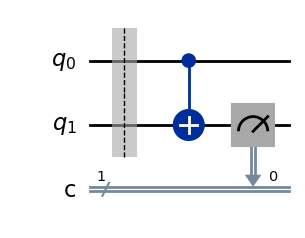

In [4]:
import qiskit as qk
import pylatexenc as pyla
qc = qk.QuantumCircuit(2,1)
qc.barrier()
qc.cx(0,1)
qc.measure(1,0)
print("Measurement in the ZZ basis")
qc.draw(output="mpl")

Other two-qubit observables can be reducted to a measurement of $Z_1 Z_2$ by means of appropriate unitary transofmations (change of basis).

#### Observable $X_1 X_2$

Using $X=HZH$ and the CNOT for measuring $Z_1 Z_2$, we have that the measurement in the $X_1 X_2$ can be achieved using the following circuit:

Measurement in the XX basis


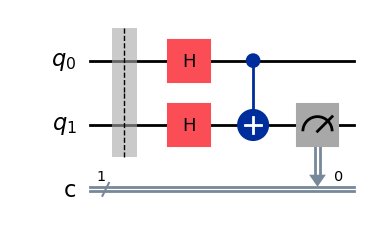

In [2]:
qc = qk.QuantumCircuit(2,1)
qc.barrier()
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.measure(1,0)
print("Measurement in the XX basis")
qc.draw(output="mpl")

#### Observable $Y_1 Y_2$

Using $Y=(HS^\dagger)^\dagger Z(HS^\dagger)$ and the CNOT for measuring $Z_1 Z_2$, we have that the measurement in the $X_1 X_2$ can be achieved using the following circuit:

Measurement in the YY basis


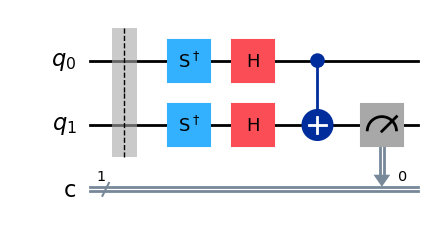

In [3]:
qc = qk.QuantumCircuit(2,1)
qc.barrier()
qc.sdg(0)
qc.sdg(1)
qc.h(0)
qc.h(1)
qc.cx(0,1)
qc.measure(1,0)
print("Measurement in the YY basis")
qc.draw(output="mpl")

## VQE

We now proceed implementing the VQE architecure, which works as follows:
* choose an ansatz for a trial state $|\psi(\theta)\rangle$, parametrized by the parameter $\theta$
* use three different quantum circuits to estimate the mean values $\langle X_1 X_2 \rangle_\theta$, $\langle Y_1 Y_2 \rangle_\theta$ and $\langle Z_1 Z_2 \rangle_\theta$, where the subscript indicate the dependece on $\theta$.
* compute the energy $E(\theta)=\langle \mathcal{H} \rangle_\theta$
* change $\theta$ in order to reach a lower energy

As suggested, we use the ansatz $|\psi(\theta)\rangle = [(RX(\theta)_1\otimes \mathbb{1}_2) \ \text{CNOT}\ (H_1\otimes \mathbb{1}_2)]|00\rangle$.

The quantum circuits are built with **Qiskit**.

###### Importation of packages

In [5]:
!pip install qiskit-aer


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 93.8 MB/s eta 0:00:00


In [2]:
!pip show qiskit-aer


Name: qiskit-aer
Version: 0.17.1
Summary: Aer - High performance simulators for Qiskit
Home-page: https://github.com/Qiskit/qiskit-aer
Author: AER Development Team
Author-email: qiskit@us.ibm.com
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: numpy, psutil, python-dateutil, qiskit, scipy
Required-by: 


In [6]:
from qiskit_aer import Aer
import numpy as np
from scipy.optimize import minimize_scalar, minimize
from numpy import pi


sim_bknd = Aer.get_backend('qasm_simulator')

###### Functions declaration

In [20]:
def ansatz(qc, qr, theta):
    """
    Builds the trial state using the ansatz: (RX I) CX (H I)|00>

    Arguments
    -----------
    qc: is a QuantumCircuit object from Qiskit
    qr: is a QuantumRegister object used in the quantum circuit qc
    theta (real): is the parameter parametrizing the trial state

    Return
    ---------
    qc: returns the input quantum circuit added with the gates creating the trial state

    """

    qc.h(qr[0])
    qc.cx(qr[0],qr[1])
    qc.rx(theta, qr[0])

    return qc

def measurements(qc, qr, cr, op):
    """
    Implements the quantum measurements in different basis: XX, YY and ZZ.

    Arguments
    -----------
    qc: is a QuantumCircuit object from Qiskit
    qr: is a QuantumRegister object used in the quantum circuit qc
    cr: is a ClassicalRegister object used in the quantum circuit qc
    op (str): is a string with possible values: XX, YY and ZZ.


    Return
    ---------
    qc: returns the input quantum circuit added with the appropriate gates to measure in the selected basis.

    """

    if op == "XX":
        # Change of basis, since X = HZH
        qc.h(qr[0])
        qc.h(qr[1])

        # CNOT used to measure ZZ operator
        qc.cx(qr[0],qr[1])

        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[1],cr[0])

    elif op == "YY":
        # Change of basis, since Y = (HS†)Z(HS†)
        qc.sdg(qr[0])
        qc.sdg(qr[1])
        qc.h(qr[0])
        qc.h(qr[1])

        # CNOT used to measure ZZ operator
        qc.cx(qr[0],qr[1])

        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[1],cr[0])

    elif op == "ZZ":
        # CNOT used to measure ZZ operator
        qc.cx(qr[0],qr[1])

        # Measurement of qubit 1 on classical register 0
        qc.measure(qr[1],cr[0])

    else:
        print(f"WARNING: Measurement on the {op} basis not supported")
        return

    return qc

def hamiltonian(params):
    """
    Evaulates the Energy of the trial state using the mean values of the operators XX, YY and ZZ.

    Arguments
    -----------
    params (dict): is an dictionary containing the mean values form the measurements of the operators XX, YY, ZZ;

    Return
    ---------
    en (real): energy of the system

    """
    # H = 1/2 * (Id + ZZ - XX - YY)
    en = (1 + params['ZZ'] - params['XX'] - params['YY']) / 2
    return en

def vqe_step(theta, verbose = True):
    """
    Executes the VQE algorithm.
    Creates and executes three quantum circuits (one for each of the observables XX, YY and ZZ), then evaluates the energy.

    Arguments
    -----------
    theta (real): is the parameter parametrizing the trial state

    Return
    --------
    energy (real): the energy of the system
    qc_list (dict): a dictionary containing the three quantum circuits for the observables XX, YY and ZZ

    """
    # Number of executions for each quantum circuit
    shots=8192

    vqe_res = dict()
    qc_list = dict()

    for op in ["XX", "YY", "ZZ"]:
        qr = qk.QuantumRegister(2, "qr")
        cr = qk.ClassicalRegister(1, "cr")
        qc = qk.QuantumCircuit(qr, cr)

        # Implementation of the ansatz
        qc = ansatz(qc, qr, theta)

        # Just for plotting purposes
        qc.barrier()

        # Measurements in the appropriate basis (XX, YY, ZZ) are implemented
        qc = measurements(qc, qr, cr, op)

        # Get the measurements results
        # counts = qk.execute(qc, sim_bknd, shots=shots).result().get_counts()

        # Check the results, and evaluate the mean value dividing by the number of shots
        if len(counts) == 1:
            try:
                counts['0']
                mean_val = 1
            except:
                mean_val = -1
        else:
            # Evaluates the mean value of Z operator, as the difference in the number of
            # 0s and 1s in the measurement outcomes
            mean_val = (counts['0']-counts['1'])/shots

        vqe_res[op] = mean_val
        qc_list[op] = qc

    energy = hamiltonian(vqe_res)

    if verbose:
        print("Mean values from measurement results:\n", vqe_res)
        print(f"\n{'Theta':<10} {'Energy':<10} {'<XX>':<10} {'<YY>':<10} {'<ZZ>':<10}")
        print(f"{theta:<10f} {energy:<10f} {vqe_res['XX']:<10f} {vqe_res['YY']:<10f} {vqe_res['ZZ']:<10f}")

        return energy, qc_list

    else:
        return energy

In [14]:
!pip install qiskit.primitives

ERROR: Could not find a version that satisfies the requirement qiskit.primitives (from versions: none)
ERROR: No matching distribution found for qiskit.primitives


In [11]:
!pip install qiskit qiskit-aer qiskit-primitives --upgrade


ERROR: Could not find a version that satisfies the requirement qiskit-primitives (from versions: none)
ERROR: No matching distribution found for qiskit-primitives


In [19]:
# from qiskit import QuantumCircuit
# from qiskit.primitives import StatevectorSampler as Sampler
# # Créer un circuit
# qc = QuantumCircuit(2)
# qc.h(0)
# qc.cx(0, 1)
# qc.measure_all()

# # Utiliser Sampler
# sampler = Sampler()
# job = sampler.run([qc])  # ✅ liste ici
# result = job.result()

# # Afficher les résultats
# print(result)



PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'shots': 1024, 'circuit_metadata': {}})], metadata={'version': 2})


Let's try if it all works properly:

In [ ]:
# Set the value of theta
theta = 0.2

# Run the VQE step to evaluate the energy (eigenvalue of the Hamiltonian) of the state with given theta
energy, qc_list = vqe_step(theta)

# Plot the circuit used for the measurement of YY
op = 'YY'
print(f"\nQuantum circuit for the measurement of {op}")
qc_list[op].draw(output="mpl")

We see that for $\theta=0.2$, the energy $E(0.2)=\langle\mathcal{H}\rangle_{0.2} \sim 0.98$. Our aim is to find a value for the parameter that yields the lowest possible energy, and that is the desired lowest eigenvalue for the Task.  
The minimization procedure can be done by hand, or by setting up an optimizator.

##### Using an optimizator

In [ ]:
minimize_scalar(vqe_step, args=(False), bounds = (0, pi), method = "bounded")

     fun: -1.0
 message: 'Solution found.'
    nfev: 27
  status: 0
 success: True
       x: 3.141586540251999

##### Conclusion
We see that the optimizator succeds in finding a solution. In particular, the optimal value seems to be $\theta \sim \pi$, and its energy is close to unity.
We can then check this result directly feeding $\theta = \pi$ to the `vqe_step` function:

In [ ]:
lowest, _ = vqe_step(pi)

Mean values from measurement results:
 {'XX': 1, 'YY': 1, 'ZZ': -1}

Theta      Energy     <XX>       <YY>       <ZZ>      
3.141593   -1.000000  1.000000   1.000000   -1.000000 


And we can actually see that our desired result is indeed given by:

$$
\langle \mathcal{H} \rangle_{\theta = \pi} = \frac{1}{2}(1 + \langle Z Z\rangle)-\frac{1}{2}(\langle X X\rangle+\langle Y Y\rangle) \\
 = -1
$$  

with $\langle XX \rangle = 1$, $\langle YY \rangle = 1$, $\langle ZZ \rangle = -1$.  

**Thus, we found the solution to the Task, that is the lowest eigenvalue of $\mathcal{H}$ (formerly $U$), which amounts to $-1$.**

###### Final (classical) check
As a final step, we can check the result of our calculation with Scipy's eigensolver.

In [ ]:
# Definition of one qubit Pauli matrices
I = np.array([[1,0],[0,1]])
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])

# Evaluation of two qubit Pauli matrices
II = np.kron(I,I)
XX = np.kron(X,X)
YY = np.kron(Y,Y)
ZZ = np.kron(Z,Z)

# Calculation of the Hamiltonian
H = (1/2) * (II+ZZ) - (1/2) * (XX+YY)

print("Desired Hamiltionian H = \n", H)

Desired Hamiltionian H = 
 [[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


Which is the same as $U$. Now we proceed calculating the eigenvalues:

In [ ]:
import scipy

# Calculate eigenvalues and eigenvectors of H
eigenvalues, eigenvectors = scipy.linalg.eig(H)
print("Eigenvalues:", eigenvalues)

Eigenvalues: [ 1.+0.j -1.+0.j  1.+0.j  1.+0.j]


We see that $-1$ is actually the lowest eigenvalue, as we found with VQE.